In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
import os
import sys
import datetime

writer = SummaryWriter(log_dir="runs/test")

# Add the project root to sys.path
sys.path.append(os.path.abspath(".."))
from model_trainer import model_trainer

version = "v3"
os.makedirs(version, exist_ok=True)
data_prep = f"{version}/data_preparation.py"
model_config = f"{version}/model_config.py"
model_train = f"{version}/model_training.py"

In [2]:
%%writefile $data_prep
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)

class Custom_dataset(Dataset):
    def __init__(self, features, labels):
        self.x = features
        self.y = labels

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

w = 0.5
b = 1.2

x = torch.linspace(0, 1, 100)
y = (w * x + b)

dataset = Custom_dataset(x, y)

n_train = int(len(dataset) * 0.8)
n_val = len(dataset) - n_train

train_data, val_data = random_split(dataset=dataset, lengths=[n_train, n_val])

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16, shuffle=True)

Overwriting v3/data_preparation.py


In [3]:
%%writefile $model_config

lr = 0.1

torch.manual_seed(42)

class Linear_regression_model_class(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(1,1)

  def forward(self, x):
    return self.linear(x)

model = Linear_regression_model_class()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss(reduction="mean")

print(model.state_dict())

Overwriting v3/model_config.py


In [4]:
%%writefile $model_train

trainer = model_trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
trainer.set_loaders(train_loader=train_loader, val_loader=val_loader)
trainer.set_tensorboard(name="classy")

trainer.train(epochs=100)
print(trainer.model.state_dict())
trainer.plot_losses()

Overwriting v3/model_training.py


OrderedDict({'linear.weight': tensor([[0.7645]]), 'linear.bias': tensor([0.8300])})
OrderedDict({'linear.weight': tensor([[0.7540]], device='cuda:0'), 'linear.bias': tensor([1.0513], device='cuda:0')})


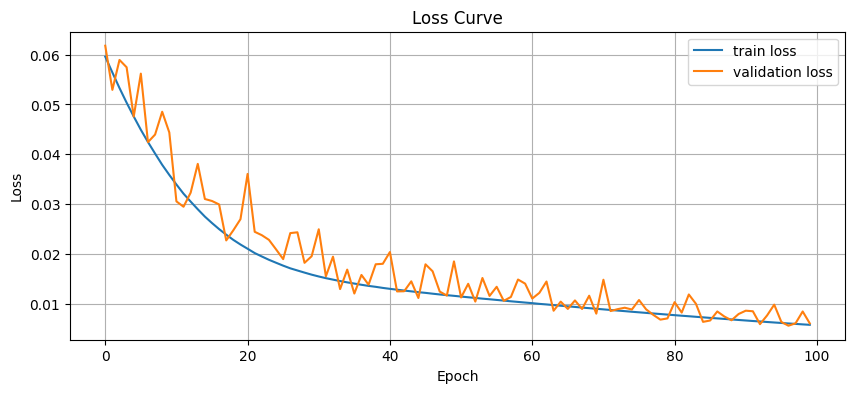

In [5]:
%run -i $data_prep
%run -i $model_config
%run -i $model_train